## Identify peaks per cluster

In [14]:
import os
import sys
import loompy
import numpy as np
import pybedtools
from pybedtools import BedTool

from chromograph.preprocessing.utils import *
from chromograph.pipeline import config
config = config.load_config()

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

# sample = sys.argv[1]
sample = 'SF11215'

file = os.path.join(config.paths.samples, f'10X{sample}', f'10X{sample}_20kb.loom')
fdir = os.path.join(config.paths.samples, f'10X{sample}', 'fragments')
ff = os.path.join('/data/proj/tumor/Kriegstein/ATAC_cellranger',  f'10X{sample}','outs/fragments.tsv.gz')

## Read Fragments and generate size bins
logging.info("Read fragments into dict")
frag_dict = read_fragments(ff)

10:11:39 INFO     Read fragments into dict
10:14:23 INFO     barcodes: 873   fragments: 53894596


10:26:05 INFO     barcoees with missing values 0


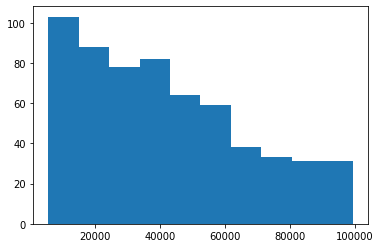

In [19]:
tmp = []

with loompy.connect(file, 'r') as ds:
    barcodes = np.unique(ds.ca.barcode)
    i = 0
    for x in barcodes:
        try:
            tmp.append(BedTool(frag_dict[x]).count())
        except:
            i += 1        
        
plt.hist(tmp)
logging.info(f'barcoees with missing values {i}')

In [29]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200611/All/All_peaks.loom', 'r') as ds:
    print(ds.ra.keys())
    print(ds.ra.ID[:10])

['Annotation', 'Chr', 'CpG%', 'Detailed Annotation', 'Distance to TSS', 'End', 'Entrez ID', 'Focus Ratio-Region Size', 'GC%', 'Gene Alias', 'Gene Description', 'Gene Name', 'Gene Type', 'ID', 'NCells', 'Nearest Ensembl', 'Nearest PromoterID', 'Nearest Refseq', 'Nearest Unigene', 'Peak Score', 'Start', 'Strand']
['chr1:10155-10326' 'chr1:181364-181783' 'chr1:190752-191885'
 'chr1:778234-779397' 'chr1:794862-795186' 'chr1:817042-817492'
 'chr1:817964-818355' 'chr1:818935-819622' 'chr1:821232-821611'
 'chr1:826712-827920']


In [7]:
## Split fragments to seperate files for fast indexing
logging.info(f"Saving fragments to separate folder for fast indexing")
if not os.path.isdir(fdir):
    os.mkdir(fdir)


## Save fragments to folder
with loompy.connect(file, 'r') as ds:
    barcodes = np.unique(ds.ca.barcode)
    i = 0
    for x in barcodes:
        f = os.path.join(fdir, f'{x}.tsv.gz')
        frags = BedTool(frag_dict[x]).saveas(f)
        i += 1
        if i%1000 == 0:
            logging.info(f'Finished separating fragments for {i} cells')
            
logging.info(f'Exported all fragments for {sample}')

/data/proj/scATAC/samples


In [23]:
# cBed = BedTool('/data/proj/scATAC/samples/10XSF11612/fragments/GGTTGCGTCCCGATTC-1.tsv.gz').remove_invalid()
cBed = BedTool('/data/proj/scATAC/samples/10XSF11612/fragments/GGTTGCGTCCCGATTC-1.tsv.gz').sort()
peaks = BedTool('/proj/DEV_ATAC/Kriegstein_20200711/All/peaks/Compounded_peaks.bed')

inter = peaks.intersect(cBed, wa=True)

In [1]:
import numpy as np
import os
import sys
import logging
import collections
import matplotlib.pyplot as plt
import gzip
import glob
import loompy
import pybedtools
from pybedtools import BedTool
import multiprocessing as mp
from typing import *

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *            
from chromograph.pipeline import config
from chromograph.peak_calling import call_MACS
import shutil

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

from chromograph.pipeline import config
config = config.load_config()

# # Parameters
# ds = loompy.connect('/data/proj/scATAC/chromograph/build_20191206/Cerebellum.loom')
# logging.info(f'ds connection: {ds.shape}')

In [3]:
from chromograph.peak_calling.utils import export_bigwig

f1 = '/data/proj/scATAC/samples/10XSF11964/fragments/TCAAGACAGAGAACCC-1.tsv.gz'
f2 = '/proj/DEV_ATAC/Kriegstein_20200711/All/peaks/Compounded_peaks.bed'

cBed = BedTool(f1)
peaks = BedTool(f2)

pks = peaks.intersect(cBed, wa=True)

BEDToolsError: 
Command was:

	bedtools intersect -wa -b /data/proj/scATAC/samples/10XSF11964/fragments/TCAAGACAGAGAACCC-1.tsv.gz -a /proj/DEV_ATAC/Kriegstein_20200711/All/peaks/Compounded_peaks.bed

Error message was:
Error: line number 32060 of file /data/proj/scATAC/samples/10XSF11964/fragments/TCAAGACAGAGAACCC-1.tsv.gz has 2 fields, but 3 were expected.


In [4]:
cBed.count()

32252

## Bigwig

In [77]:
## Create an example pileup
fdir = '/data/proj/scATAC/chromograph/build_20200513_glioma/Glioma/'
f = os.path.join(fdir, 'Glioma.loom')
fsamples = '/data/proj/scATAC/samples'
peakdir = '/data/proj/scATAC/chromograph/tmp/peaks'

with loompy.connect(f, 'r') as ds:
    chunks = []
    for i in np.unique(ds.ca.Clusters):
        cells = [x.split(':') for x in ds.ca['CellID'][ds.ca['Clusters'] == i]]
        files = [os.path.join(fsamples, x[0], 'fragments', f'{x[1]}.tsv.gz') for x in cells]
        if len(cells) > 50:
            chunks.append([i,files])

    logging.info('Start merging fragments by cluster')
    piles = []
    for ck in chunks:
        files = np.array(ck[1])
        ex = np.array([os.path.exists(x) for x in files])
        files = files[ex]

        fmerge = os.path.join(peakdir, f'fragments_{ck[0]}.tsv.gz')
        with open(fmerge, 'wb') as out:
            for f in files:
                with open(f, 'rb') as file:
                    shutil.copyfileobj(file, out)
        piles.append([ck[0], fmerge])
        logging.info(f'Finished with cluster {ck[0]}')
   
    logging.info('Downsample')
    for pile in piles:
        bed_downsample(pile, 2.5e7)
        
    for pile in piles:
        f_unzip = f'{pile[1].split(".")[0]}.tsv'
        f_sort = f'{pile[1].split(".")[0]}_sorted.bed'
        os.system(f'gunzip {pile[1]}')
        cmd = f'sort -k 1,1 -k2,2n {f_unzip} > {f_sort}'
        os.system(cmd)
        
        ## Save only sorted result
        os.system(f'rm {pile[1]} {f_unzip}')
        pile[1] = f_sort
        logging.info(f'finished sorting {pile[0]}')

13:19:43 INFO     Start merging fragments by cluster
13:19:44 INFO     Finished with cluster 0
13:19:45 INFO     Finished with cluster 1
13:19:46 INFO     Finished with cluster 2
13:19:47 INFO     Finished with cluster 3
13:19:48 INFO     Finished with cluster 4
13:19:50 INFO     Finished with cluster 5
13:19:52 INFO     Finished with cluster 6
13:19:52 INFO     Finished with cluster 7
13:19:53 INFO     Finished with cluster 8
13:19:54 INFO     Finished with cluster 9
13:19:55 INFO     Finished with cluster 10
13:19:55 INFO     Finished with cluster 11
13:19:58 INFO     Finished with cluster 12
13:19:59 INFO     Finished with cluster 13
13:20:01 INFO     Finished with cluster 14
13:20:01 INFO     Finished with cluster 15
13:20:03 INFO     Finished with cluster 16
13:20:03 INFO     Downsample
13:20:23 INFO     cluster 0 was not downsampled
13:20:37 INFO     cluster 1 was not downsampled
13:20:57 INFO     cluster 2 was not downsampled
13:21:07 INFO     cluster 3 was not downsampled
13:21

chr1	88262	88705
 chr1	135189	135222
 chr1	183795	183826
 chr1	191414	191567
 chr1	202474	202518
 chr1	277594	277629
 chr1	629918	629957
 chr1	629925	630034
 chr1	631733	632053
 chr1	634005	634051
 None


13:25:41 INFO     finished sorting 1


chr1	85704	85789
 chr1	181428	181463
 chr1	181466	181520
 chr1	599309	599398
 chr1	777907	777935
 chr1	778370	778618
 chr1	778429	778637
 chr1	778570	778663
 chr1	778575	778615
 chr1	778608	778687
 None


13:26:13 INFO     finished sorting 2


chr1	17408	17494
 chr1	77060	77127
 chr1	78907	79098
 chr1	181421	181712
 chr1	181473	181629
 chr1	181519	181548
 chr1	182461	182809
 chr1	184302	184494
 chr1	191422	191509
 chr1	191439	191503
 None


13:26:30 INFO     finished sorting 3


chr1	16236	16267
 chr1	191311	191344
 chr1	191318	191503
 chr1	191526	191743
 chr1	268717	269067
 chr1	274012	274087
 chr1	629913	630434
 chr1	629918	629962
 chr1	634006	634038
 chr1	634015	634037
 None


13:26:57 INFO     finished sorting 4


chr1	79651	80048
 chr1	181348	181505
 chr1	181479	181780
 chr1	191316	191532
 chr1	191412	191558
 chr1	191426	191863
 chr1	191429	191496
 chr1	191437	191483
 chr1	191447	191560
 chr1	191450	191560
 None


13:27:25 INFO     finished sorting 5


chr1	181471	181602
 chr1	184459	184728
 chr1	191415	191481
 chr1	191415	191488
 chr1	191421	191483
 chr1	191427	191535
 chr1	191429	191532
 chr1	191432	191493
 chr1	191445	191554
 chr1	191530	191709
 None


13:27:55 INFO     finished sorting 6


chr1	181434	181576
 chr1	182024	182053
 chr1	184459	184742
 chr1	190815	191066
 chr1	190824	190934
 chr1	191236	191445
 chr1	191412	191509
 chr1	191415	191501
 chr1	191415	191542
 chr1	191422	191501
 None


13:28:17 INFO     finished sorting 7


chr1	181044	181166
 chr1	191254	191450
 chr1	191422	191491
 chr1	191530	191588
 chr1	191530	191706
 chr1	586196	586221
 chr1	629758	629942
 chr1	629925	629967
 chr1	629927	630148
 chr1	633957	634045
 None


13:28:26 INFO     finished sorting 8


chr1	118581	118777
 chr1	181369	181457
 chr1	191422	191450
 chr1	191479	191535
 chr1	634015	634057
 chr1	729357	729709
 chr1	778477	778554
 chr1	778553	778712
 chr1	778599	778667
 chr1	778602	778750
 None


13:28:54 INFO     finished sorting 9


chr1	55506	55572
 chr1	184460	184695
 chr1	186609	186924
 chr1	190822	191048
 chr1	190971	191045
 chr1	191377	191530
 chr1	191525	191708
 chr1	278060	278163
 chr1	606596	606824
 chr1	629913	629957
 None


13:29:17 INFO     finished sorting 10


chr1	16236	16270
 chr1	181109	181260
 chr1	181129	181160
 chr1	181357	181547
 chr1	181446	181506
 chr1	181470	181495
 chr1	184468	184579
 chr1	190822	191044
 chr1	191377	191535
 chr1	191411	191447
 None


13:29:32 INFO     finished sorting 11


chr1	10157	10186
 chr1	133146	133200
 chr1	181350	181381
 chr1	181434	181481
 chr1	191412	191447
 chr1	191428	191509
 chr1	191526	191557
 chr1	191526	191838
 chr1	729357	729703
 chr1	733826	733893
 None


13:30:26 INFO     finished sorting 12


chr1	17478	17556
 chr1	87163	87202
 chr1	88302	88719
 chr1	109155	109198
 chr1	123757	123797
 chr1	181047	181160
 chr1	181247	181393
 chr1	181357	181451
 chr1	181376	181488
 chr1	181405	181466
 None


13:31:02 INFO     finished sorting 13


chr1	55499	55562
 chr1	89840	89896
 chr1	180991	181160
 chr1	181441	181479
 chr1	181446	181556
 chr1	182771	182855
 chr1	184459	184507
 chr1	184459	184641
 chr1	186997	187080
 chr1	190815	190980
 None


13:31:39 INFO     finished sorting 14


chr1	10247	10309
 chr1	17298	17506
 chr1	55546	55680
 chr1	64567	64676
 chr1	88158	88193
 chr1	101802	101842
 chr1	115635	115752
 chr1	180513	180916
 chr1	181095	181124
 chr1	181323	181458
 None


13:32:00 INFO     finished sorting 15


chr1	16216	16248
 chr1	79639	79704
 chr1	181248	181446
 chr1	181389	181531
 chr1	181402	181494
 chr1	184326	184480
 chr1	185704	185852
 chr1	190820	191008
 chr1	190961	191264
 chr1	190973	191344
 None


13:32:24 INFO     finished sorting 16


chr1	10085	10273
 chr1	48165	48192
 chr1	87148	87441
 chr1	180798	181032
 chr1	181124	181151
 chr1	181129	181271
 chr1	181346	181462
 chr1	181431	181500
 chr1	181446	181519
 chr1	190819	191044
 None


In [ ]:
def export_bigwig(ds: loompy.LoomConnection, sample_dir, peak_dir, cluster):
    '''
    Calculates coverage for a cluster and exports as a bigwig file
    '''
    cells = [x.split(':') for x in ds.ca['CellID'][ds.ca['Clusters'] == i]]
    files = np.array([os.path.join(sample_dir, x[0], 'fragments', f'{x[1]}.tsv.gz') for x in cells])

    ## Check if all files exist
    ex = np.array([os.path.exists(x) for x in files])
    files = files[ex]

    fmerge = os.path.join(peak_dir, f'fragments_{cluster}.tsv.gz')
    with open(fmerge, 'wb') as out:
        for f in files:
            with open(f, 'rb') as file:
                shutil.copyfileobj(file, out)
    logging.info(f'Finished merging files')
    
    ## Downsample
    bed_downsample([cluster, fmerge], 2.5e7)
   
    ## Unzip and sort
    f_unzip = f'{fmerge.split(".")[0]}.tsv'
    f_sort = f'{fmerge.split(".")[0]}_sorted.bed'
    os.system(f'gunzip {fmerge}')
    os.system(f'sort -k 1,1 -k2,2n {f_unzip} > {f_sort}')
    os.system(f'rm {fmerge} {f_unzip}')
    logging.info(f'finished sorting')
    
    ## Calculate coverage and scale to CPM
    cov = 1e6 / BedTool(f_sort).count()
    f_bg = f'{f_sort.split(".")[0]}.bdg'
    f_genome = os.path.join(chromograph.__path__[0], 'references/male.GRCh38.chrom.sizes')
    os.system(f'bedtools genomecov -i {f_sort} -g {f_genome} -scale {cov} -bg > {f_bg}')
    
    ## Convert to bigwig
    outfile = os.path.join(peak_dir, f'cluster_{str(cluster)}.bw')
    pybedtools.contrib.bigwig.bedgraph_to_bigwig(BedTool(f_bg), genome='hg38', output=outfile)
    
    ## Clean up
    os.system(f'rm {f_bg} {f_sort}')        4
    logging.info(f'Exported bigwig for cluster {cluster}')
    
    return

## Create an example pileup
build = '/data/proj/scATAC/chromograph/build_20200611/Cerebellum'
peak_dir = os.path.join(build, 'peaks')
fsamples = '/data/proj/scATAC/samples'
f = os.path.join(build, 'Cerebellum_GA.loom')

with loompy.connect(f, 'r') as ds:
    for i in np.unique(ds.ca.Clusters):
        export_bigwig(ds, fsamples, peak_dir, cluster = i)

16:34:18 INFO     Finished merging files
16:34:23 INFO     cluster 0 was not downsampled
16:34:31 INFO     finished sorting
16:35:00 INFO     Exported bigwig for cluster 0
16:36:46 INFO     Finished merging files
16:50:56 INFO     Total fragments: 90237522 in cluster 1, downsampled to 24996909
16:53:47 INFO     finished sorting
16:57:35 INFO     Exported bigwig for cluster 1
16:59:06 INFO     Finished merging files
17:13:04 INFO     Total fragments: 89456720 in cluster 2, downsampled to 25007089
17:15:54 INFO     finished sorting
17:19:45 INFO     Exported bigwig for cluster 2
17:19:49 INFO     Finished merging files
17:19:58 INFO     cluster 3 was not downsampled
17:20:13 INFO     finished sorting
17:20:51 INFO     Exported bigwig for cluster 3
17:20:56 INFO     Finished merging files
17:21:05 INFO     cluster 4 was not downsampled
17:21:21 INFO     finished sorting
17:21:58 INFO     Exported bigwig for cluster 4
17:22:01 INFO     Finished merging files
17:22:07 INFO     cluster 5 was

In [87]:
## Calculate genomve coverage
for pile in piles:
    cov = 1e6 / BedTool(pile[1]).count()
    f_bg = f'{pile[1].split(".")[0]}.bdg'
    f_genome = os.path.join(chromograph.__path__[0], 'references/male.GRCh38.chrom.sizes')
    cmd = f'bedtools genomecov -i {pile[1]} -g {f_genome} -scale {cov} -bg > {f_bg}'
    os.system(cmd)
    
    outfile = os.path.join(peakdir, f'cluster_{str(pile[0])}.bw')
    pybedtools.contrib.bigwig.bedgraph_to_bigwig(BedTool(f_bg), genome='hg38', output=outfile)
    
    os.system(f'rm {f_bg} {pile[1]}')
    logging.info(f'Converted to bigwig {pile[0]}')

14:47:14 INFO     Finished calculating coverage for 0
14:48:06 INFO     Finished calculating coverage for 1
14:49:07 INFO     Finished calculating coverage for 2
14:49:45 INFO     Finished calculating coverage for 3
14:50:38 INFO     Finished calculating coverage for 4
14:51:35 INFO     Finished calculating coverage for 5
14:52:32 INFO     Finished calculating coverage for 6
14:53:22 INFO     Finished calculating coverage for 7
14:53:51 INFO     Finished calculating coverage for 8
14:54:48 INFO     Finished calculating coverage for 9
14:55:36 INFO     Finished calculating coverage for 10
14:56:15 INFO     Finished calculating coverage for 11
14:57:54 INFO     Finished calculating coverage for 12
14:59:02 INFO     Finished calculating coverage for 13
15:00:08 INFO     Finished calculating coverage for 14
15:00:55 INFO     Finished calculating coverage for 15
15:01:45 INFO     Finished calculating coverage for 16


In [26]:
# # pybedtools.helpers.set_bedtools_path("/home/camiel/anaconda3/envs/chromograph/bin/")
f = '/data/proj/scATAC/chromograph/build_20191205/peaks/NA_treat_pileup.bdg'
f2 = '/data/proj/scATAC/chromograph/tmp/peaks/sorted.bdg'
# cmd = f'sort -k1,1 -k2,2 {f} > {f2}'
# os.system(cmd)
cov = BedTool(f)

# outfile = '/data/proj/scATAC/chromograph/tmp/peaks/NA_pileup.bw'
# pybedtools.contrib.bigwig.bedgraph_to_bigwig(cov, genome='hg38', output=outfile)
# f'~/anaconda3/envs/chromograph/bin/bedGraphToBigWig {f} /home/camiel/chromograph/chromograph/references/male.GRCh38.chrom.sizes {outfile}'

In [46]:
f = '/data/proj/scATAC/chromograph/tmp/peaks/cluster_1_copy.bdg'
cov = BedTool(f)

outfile = '/data/proj/scATAC/chromograph/tmp/peaks/test_pile.bw'
pybedtools.contrib.bigwig.bedgraph_to_bigwig(cov, genome='hg38', output=outfile)

'/data/proj/scATAC/chromograph/tmp/peaks/test_pile.bw'

In [44]:
f = '/data/proj/scATAC/chromograph/tmp/peaks/cluster_1_treat_pileup.bdg'
cov = BedTool(f)
cov.tail()

chrY	56879856	56881549	0.00000
chrY	56881549	56881620	0.04012
chrY	56881620	56882796	0.00000
chrY	56882796	56882973	0.04012
chrY	56882973	56884615	0.00000
chrY	56884615	56884794	0.04012
chrY	56884794	56886330	0.00000
chrY	56886330	56886567	0.04012
chrY	56886567	56886870	0.00000
chrY	56886870	56887056	0.04012



## Downsample

In [2]:
f = ['test', '/home/camiel/chromograph/notebooks/tmp/fragments_0.tsv.gz']
chromograph.peak_calling.utils.bed_downsample(f, 1e6)

18:08:45 INFO     cluster test has fraction: 0.07093095028038296
18:09:57 INFO     Total fragments: 14098218 in cluster test, downsampled to 998549


In [14]:
from tqdm import tqdm

f = '/data/proj/scATAC/samples/10X232_3/fragments/CTGGCAGAGTCGTACT-1.tsv.gz'
f_all = '/data/proj/scATAC/chromograph/build_20200426/All/peaks/Compounded_peaks.bed'
tmp = BedTool(f)
peaks = BedTool(f_all)
              
pks = peaks.intersect(tmp, wa=True)

i = 1

for x in tqdm(pks):
    i += 1
print(i)

100%|██████████| 15569/15569 [00:00<00:00, 139146.98it/s]

15570


## Compare peak files

In [2]:
f_cerebellum = '/data/proj/scATAC/chromograph/build_20200426/Cerebellum/peaks/Compounded_peaks.bed'
f_all = '/data/proj/scATAC/chromograph/build_20200426/All/peaks/Compounded_peaks.bed'

In [3]:
Cerebellum = BedTool(f_cerebellum)
All = BedTool(f_all)

In [4]:
Count_Cerebellum = Cerebellum.count()
Count_all = All.count()

logging.info(f'Peaks in Cerebellum: {Count_Cerebellum}. Count in full set: {Count_all}')

17:03:44 INFO     Peaks in Cerebellum: 289275. Count in full set: 436220


In [7]:
inter = Cerebellum.intersect(All, wa=True).count()
logging.info(f'Cerebellum peaks in full set {inter}, {(inter/Count_Cerebellum)*100} %')

17:06:19 INFO     Cerebellum peaks in full set 247820, 85.66934577823871 %


## Explore peaks

In [8]:
## Merge Peak lists
peakdir = '/data/proj/scATAC/chromograph/build_20200414_Hindbrain/peaks/'

In [3]:
peaks = BedTool(os.path.join(peakdir, 'Compounded_peaks.bed'))
l = peaks.count()

logging.info(f'Length of the BedTools: {l}')

10:42:12 INFO     Length of the BedTools: 270213


In [4]:
f_annot = os.path.join(peakdir, 'annotated_peaks.txt')
cols, table = read_HOMER_annotation(f_annot)
table.shape

(270213, 21)

In [7]:
peak_IDs = np.array([x[3] for x in peaks])

table = reorder_by_IDs(table, peak_IDs)

In [8]:
## Save as dict    
annot = {cols[i]: table[:,i] for i in range(table.shape[1])}

In [44]:
annot

{'ID': array(['chr1:28958-29333', 'chr1:180967-181164', 'chr1:181357-181709',
        ..., 'chrY:56839027-56839223', 'chrY:56842612-56842884',
        'chrY:56855817-56856007'], dtype=object),
 'Chr': array(['chr1', 'chr1', 'chr1', ..., 'chrY', 'chrY', 'chrY'], dtype=object),
 'Start': array(['28959', '180968', '181358', ..., '56839028', '56842613',
        '56855818'], dtype=object),
 'End': array(['29333', '181164', '181709', ..., '56839223', '56842884',
        '56856007'], dtype=object),
 'Strand': array(['+', '+', '+', ..., '+', '+', '+'], dtype=object),
 'Peak Score': array(['.', '.', '.', ..., '.', '.', '.'], dtype=object),
 'Focus Ratio/Region Size': array(['NA', 'NA', 'NA', ..., 'NA', 'NA', 'NA'], dtype=object),
 'Annotation': array(['promoter-TSS (ENST00000473358.1)', 'Intergenic', 'Intergenic',
        ..., 'Intergenic', 'Intergenic', 'TTS (ENST00000431853.1)'],
       dtype=object),
 'Detailed Annotation': array(['lincRNA-promoter-TSS (ENST00000473358.1)', 'Intergenic',
   

In [10]:
r_dict = {k: v for v,k in enumerate(annot['ID'])}

In [ ]:
def plot_peak_annotation_wheel(annotation, outfile):
    '''
    '''
    simple_annotation = np.array([x.split(' ')[0] for x in annotation['Annotation']])

    counts = {}
    for x in np.unique(simple_annotation):
        counts[x] = np.sum(simple_annotation == x)
        
    labels = 'Intergenic', 'Intron', 'Promoter-TSS', 'Exon', 'TTS'

    fig, ax = plt.subplots(figsize = (12,10))
    plt.rcParams["font.size"] = "10"

    size = 0.4
    vals = np.array([counts[x] for x in labels])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(2)*4 + 1)[[1,0],:]
    inner_colors = cmap(np.array([0,1,2,3,4]))[::-1,:]

    ax.pie([vals[0], sum(vals[1:])], radius=1, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, autopct=lambda pct: func(pct, vals), pctdistance=1.2, 
           wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

    ax.set(aspect="equal")
    ax.set_title('Intra- vs. Intergenic Peaks', fontsize=24)

    ax.legend(wedges, labels,
              title="Regions",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.savefig(outfile)

In [ ]:
f = os.path.join('/Users/camima/data/scATAC/', 'annotated_peaks.txt')
peaks_all = BedTool(f)


In [11]:
simple_annotation = np.array([x.split(' ')[0] for x in annot['Annotation']])

counts = {}
for x in np.unique(simple_annotation):
    counts[x] = np.sum(simple_annotation == x)
    
print(counts)

{'Intergenic': 92716, 'TTS': 8049, 'exon': 12630, 'intron': 139889, 'promoter-TSS': 16929}


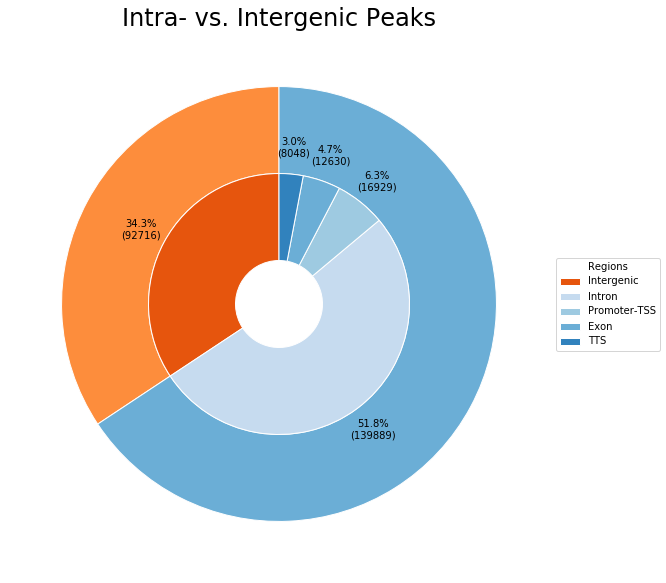

In [38]:
labels = 'Intergenic', 'Intron', 'Promoter-TSS', 'Exon', 'TTS'

fig, ax = plt.subplots(figsize = (12,10))
plt.rcParams["font.size"] = "10"

size = 0.4
vals = np.array([counts['Intergenic'], counts['intron'], counts['promoter-TSS'], counts['exon'], counts['TTS']])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4 + 1)[[1,0],:]
inner_colors = cmap(np.array([0,1,2,3,4]))[::-1,:]

ax.pie([vals[0], sum(vals[1:])], radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, autopct=lambda pct: func(pct, vals), pctdistance=1.2, 
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

ax.set(aspect="equal")
ax.set_title('Intra- vs. Intergenic Peaks', fontsize=24)

ax.legend(wedges, labels,
          title="Regions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('/data/proj/scATAC/chromograph/tmp/Midbrain_peaks.png')
plt.show()

In [21]:
peak_list = BedTool([(annot['Chr'][x], str(annot['Start'][x]), str(annot['End'][x]), str(annot['ID'][x])) for x in range(len(annot['Chr']))]).saveas()

for x in ['tss', 'transcripts', 'promoter', 'enhancer', 'dnase', 'ctcf', 'blacklist']:
    sub = BedTool(os.path.join(config.paths.ref, 'regions', f'{x}.bed'))
    peak_list = peak_list.subtract(sub, A=True)
    
for x in ['regulatory.gff', 'genes.gtf']:
    sub = BedTool(os.path.join(config.paths.ref, 'genes', x))
    peak_list = peak_list.subtract(sub, A=True)
    
peak_list.saveas()
print(peak_list.count())

22786


In [22]:
unknown_peaks = [x[3] for x in peak_list]

In [24]:
regs = []
nPeaks = len(annot['Annotation'])
for i in range(len(annot['Annotation'])):
    
    if annot['ID'][i] in unknown_peaks:
        regs.append(annot['Annotation'][i])

    if i%100000 == 0:
        logging.info(f'Finished {i} out of {nPeaks}')
unknown_annotation = np.array([x.split(' ')[0] for x in regs])

11:02:33 INFO     Finished 0 out of 270213
11:02:58 INFO     Finished 100000 out of 270213
11:03:24 INFO     Finished 200000 out of 270213


In [25]:
unk_counts = {}
for x in np.unique(unknown_annotation):
    unk_counts[x] = np.sum(unknown_annotation == x)
    
print(unk_counts)

{'Intergenic': 21954, 'TTS': 550, 'promoter-TSS': 282}


In [26]:
unk_counts['Intergenic'] / counts['Intergenic']

0.23678760947409294

## Find Differentially accessible regions for the identified clusters